# Ensemble estimators

## Introduction

In this part, we build ensemble estimators, which make predictions based on the predictions of base estimators. The goal here is to build an ensemble estimator, of which the performance is at least as good as that of the best base estimator, which help us avoid the trouble of making choices among base estimators. Such ensemble estimator would be very helpful, especially in the cases when there is variation in terms of the performance of base estimators, or in the cases where some data required for certain base estimators are not available (e.g., values of some key predictors are missing in the content filtering models).

To avoid overfitting, we train the ensemble estimators on the cross-validation set rather than the training set we used for the training of base estimators. We drop the base estimators, of which the $R^2$ score on the cross-validation set is lower than a threshold (we choose 0.05 in this case); we call the remaining base estimators as *qualified base estimators*.

Here we tried 3 strategies to build ensemble estimators (weighted average, Ridge regression, and random forest regressor).

We use Champaign dataset (20571 reviews, 878 restaurants, 8451 users) for demo purpose.

**Note:** the fitting time we report in this part does NOT include the fitting and prediction time of base estimators.
<br><br><br>

In [1]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, \
show_summaries, get_base_predictions, get_multi_base_predictions
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise, RS_ensemble

In [2]:
city = 'Champaign'
data_dir = 'data/{}/'.format(city)

results = IO(data_dir + 'results/results.pkl').read_pickle()
is_successful = IO(data_dir + 'results/is_successful.pkl').read_pickle()
datanames = IO(data_dir + 'results/datanames.pkl').read_pickle()

ys_base_train, ys_base_test, ys_base_cv, weights = get_base_predictions(results, is_successful, datanames, thres=0.05)
X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()
data_split = [ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv]
#IO(data_dir + '061_data_split.pkl').to_pickle(data_split)

## Ensemble of collaborative filtering models

First, we built ensemble estimators for the qualified collaborative filtering base estimators.

### Weighted average

The first strategy is to make the ensemble predictions as the weighted averages of the qualified base estimators, where we use $R^2$ score on the cross-validation set as weights.

The result is shown below.

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0,0.8527,1.3071,0.6454,0.1882


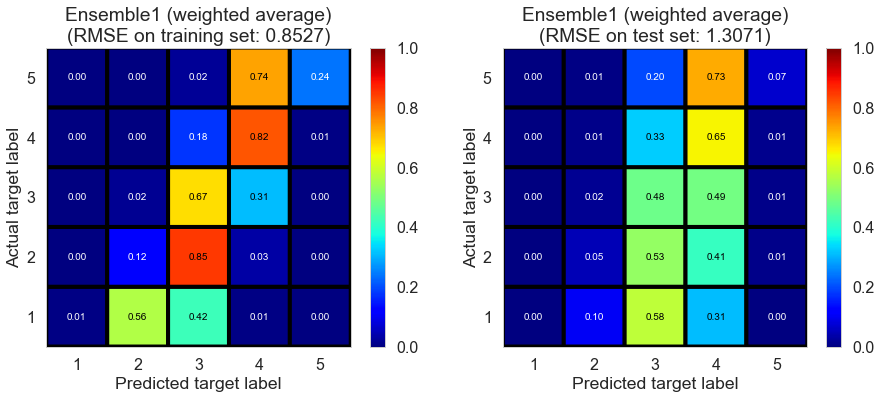

In [3]:
es = RS_ensemble(estimator=None).fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
model_name = 'Ensemble1 (weighted average)'

results = get_results(es, ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train=ys_base_train, y_train=y_train, \
             X_test=ys_base_test, y_test=y_test, print_=False, plot=True, show_cv=False, show_title=False);

The performance of weighted average is fine.
<br><br><br>

### Ridge regression

The second strategy is to perform a Ridge regression on the predictions of qualified base estimators.

The result is shown below.

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (Ridge regression),0.004,1.3268,1.3026,0.1413,0.1937


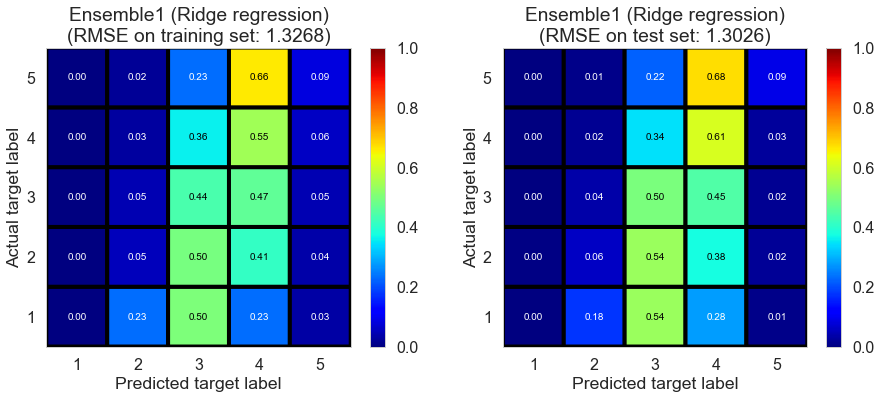

In [4]:
es = RS_ensemble(estimator=RidgeCV()).fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
model_name = 'Ensemble1 (Ridge regression)'

results = get_results(es, ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train=ys_base_train, y_train=y_train, \
             X_test=ys_base_test, y_test=y_test, print_=False, plot=True, show_cv=False, show_title=False);

The performance on the training set is poor. We need to point out that the training set here is not "real" training set since we train the ensemble estimator on the cross-validation set.
<br><br><br>

### Random forest

The third strategy is to train a random forest regressor on the predictions of qualified base estimators. We can use the best parameters determined by cross-validation.

The result is shown below.

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (random forest),0.215,1.057,1.3037,0.4551,0.1924


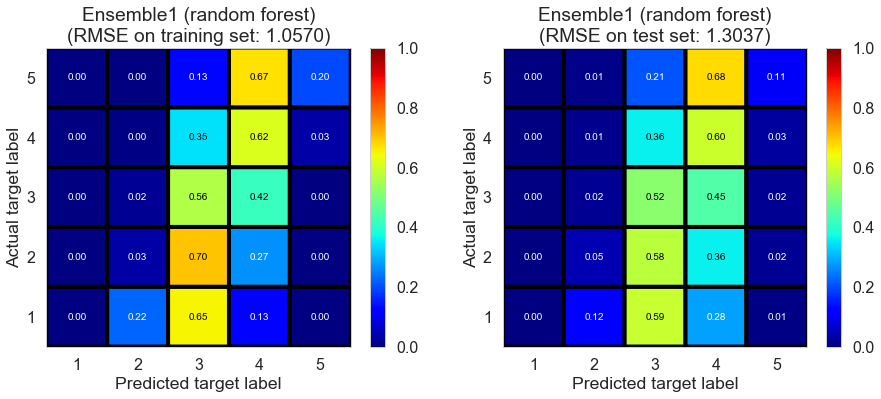

In [5]:
es = RS_ensemble(estimator=RandomForestRegressor(n_estimators=50, max_depth=3)).fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
model_name = 'Ensemble1 (random forest)'

results = get_results(es, ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train=ys_base_train, y_train=y_train, \
             X_test=ys_base_test, y_test=y_test, print_=False, plot=True, show_cv=False, show_title=False);

The performance on the training set seems to be better than that of Ridge regression.
<br><br><br>

## Ensemble of collaborative filtering and content filtering models

In [6]:
city = 'Champaign'
fig_dir = 'figs/modeling/{}/'.format(city)
data_dir = 'data/{}/'.format(city)

results = [IO(data_dir + 'results/results.pkl').read_pickle(), IO(data_dir + 'results05/results.pkl').read_pickle()]
is_successful = [IO(data_dir + 'results/is_successful.pkl').read_pickle(), \
                 IO(data_dir + 'results05/is_successful.pkl').read_pickle()]
datanames = [IO(data_dir + 'results/datanames.pkl').read_pickle(), \
             IO(data_dir + 'results05/datanames.pkl').read_pickle()]

ys_base_train, ys_base_test, ys_base_cv, weights = \
get_multi_base_predictions(results, is_successful, datanames, thres=0.05)
X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

### Weighted average

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble2 (weighted average),0.0,0.9007,1.1591,0.6043,0.3616


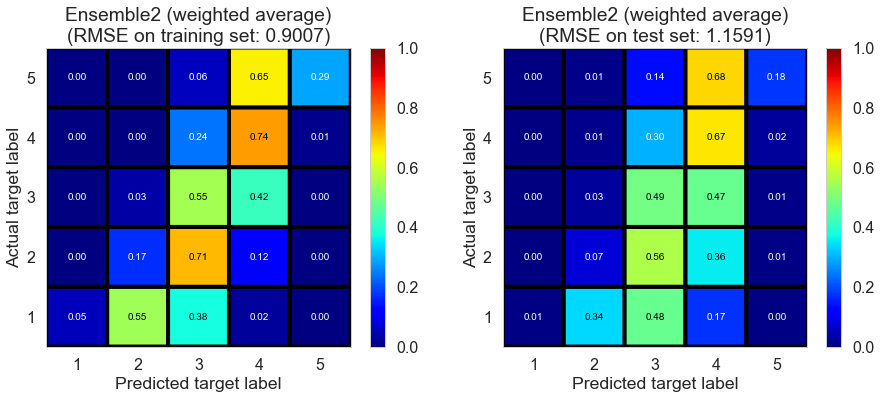

In [7]:
es = RS_ensemble(estimator=None).fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
model_name = 'Ensemble2 (weighted average)'

results = get_results(es, ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train=ys_base_train, y_train=y_train, \
             X_test=ys_base_test, y_test=y_test, print_=False, plot=True, show_cv=False, show_title=False);

The performance on the test set drops slightly.
<br><br><br>

### Ridge regression

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble2 (Ridge regression),0.01,1.2721,1.083,0.2107,0.4426


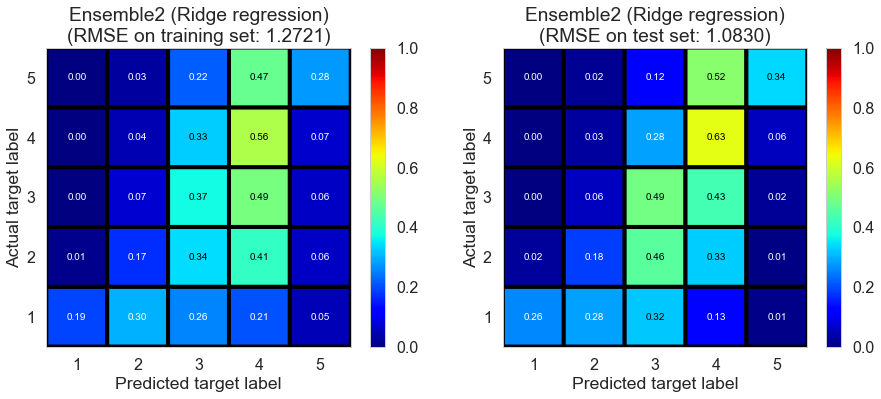

In [8]:
es = RS_ensemble(estimator=RidgeCV()).fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
model_name = 'Ensemble2 (Ridge regression)'

results = get_results(es, ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train=ys_base_train, y_train=y_train, \
             X_test=ys_base_test, y_test=y_test, print_=False, plot=True, show_cv=False, show_title=False);

The performance on the training set is bad.
<br><br><br>

### Random forest

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble2 (random forest),0.268,1.0621,1.0855,0.4497,0.4401


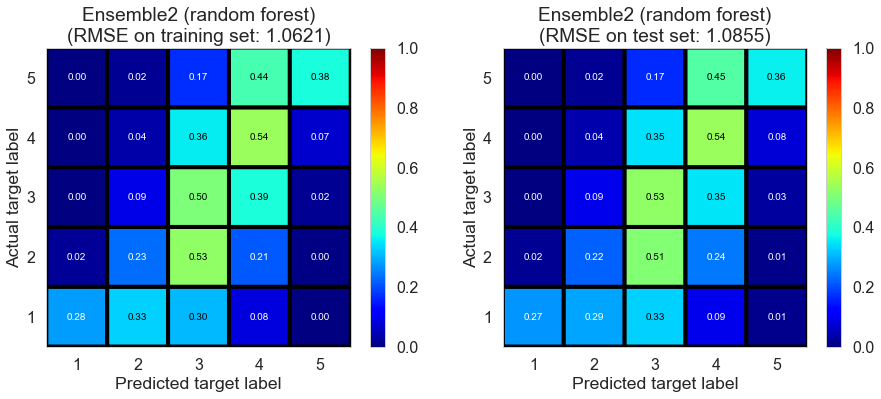

In [9]:
es = RS_ensemble(estimator=RandomForestRegressor(n_estimators=50, max_depth=3)).fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
model_name = 'Ensemble2 (random forest)'

results = get_results(es, ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train=ys_base_train, y_train=y_train, \
             X_test=ys_base_test, y_test=y_test, print_=False, plot=True, show_cv=False, show_title=False);

The performance is good on both training set and test set, indicating random forest regressor is suitable for building ensemble estimator in this case.